In [ ]:
import networkx as nx
import cvxpy as cp
import numpy as np
import scipy

# Define initial parameters

flow = scipy.io.loadmat('flow.mat')['flow'].reshape(28,)
C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)

n_nodes = B.shape[0]
n_edges = B.shape[1]

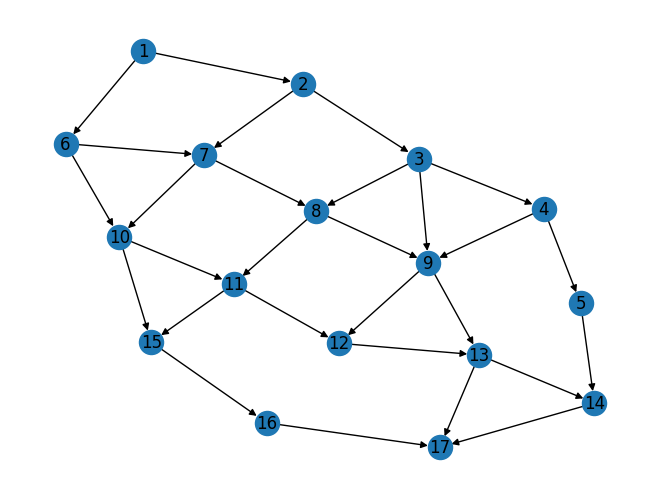

In [245]:
# Create networkx graph

edge_list = []
for col in B.T:
    tail = int(np.where(col == 1)[0][0]) + 1
    head = int(np.where(col == -1)[0][0]) + 1
    edge_list.append((tail, head))

G = nx.from_edgelist(edge_list, create_using=nx.DiGraph)
for i in range(0, n_edges):
    G.edges[edge_list[i]]['capacity'] = int(C[i])
    
pos = nx.kamada_kawai_layout(G)
pos = {node: (-x,y) for (node, (x,y)) in pos.items()}
nx.draw(G, pos, with_labels=True)

In [246]:
# A:

# define nu (exogenous flow vector) corresponding to going from node 1 to node 17:
n_nodes = B.shape[0]
n_edges = B.shape[1]
nu = np.full(shape=n_nodes, fill_value=0)
nu[0] = 1
nu[16] = -1

# define the optimization problem and solve it:
f = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)
res = prob.solve()

# clean the result by applying a threshold value:
threshold = 5e-1
f.value[f.value < threshold] = 0
f.value[f.value >= threshold] = 1
f_clean = np.array(f.value, dtype=int)

print('Optimal flow vector:', f_clean)
cost = f_clean @ l.T
print('Cost:', cost)

Optimal flow vector: [1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Cost: 0.559833


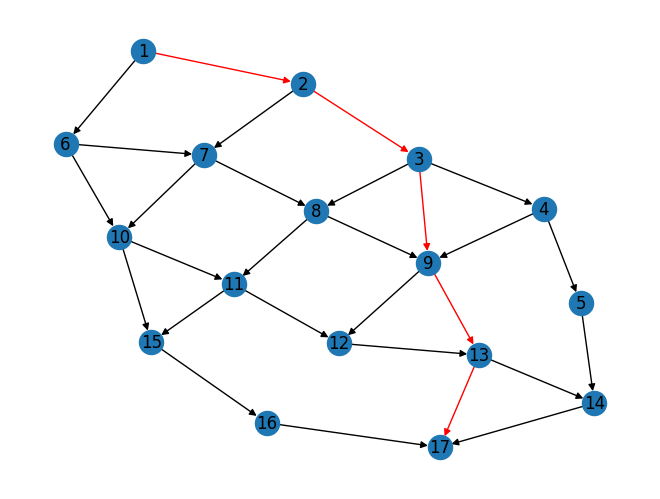

In [247]:
# Draw shortest path:
for e in edge_list:
    G.edges[int(e[0]), int(e[1])]['color'] = 'black'
    
G.edges[1, 2]['color'] = 'r'
G.edges[2, 3]['color'] = 'r'
G.edges[3, 9]['color'] = 'r'
G.edges[9, 13]['color'] = 'r'
G.edges[13, 17]['color'] = 'r'

col = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, pos, with_labels=True, edge_color = col)


In [248]:
# B:

# Find the max throughput
mt = nx.minimum_cut(G, _s=1, _t=17, capacity='capacity')[0]
print("max throughput:", mt)

# Find the max flow (set nu according to the max throughput and optimize cost)
nu[0] = mt
nu[16] = -nu[0]
f_max = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ f_max)
constraints = [B @ f_max == nu, f_max >=0, f_max<=C]
prob = cp.Problem(objective, constraints)
res = prob.solve()

f_max.value[f_max.value < threshold] = 0
f_max = np.rint(f_max.value)
print("max flow:", f_max)



max throughput: 22448
max flow: [ 8741.  8741.     0.     0. 13707.  5449.  5449.  5449.  6297.     0.
     0.  8741.     0.     0.  8258.     0.  8258.     0.     0.  7893.
     0.  7893.  3835.     0. 10355.  3835.  8258.  8258.]


{(1, 2): Text(-0.30996390327342493, 0.9202348934374538, '8741'),
 (2, 3): Text(0.0852289845139329, 0.6618124490368518, '8741'),
 (1, 6): Text(-0.6502031835328423, 0.7776020331258409, '13707'),
 (6, 7): Text(-0.5627513243035035, 0.527638167341556, '5449'),
 (7, 8): Text(-0.20290621804979248, 0.3657656898774193, '5449'),
 (8, 9): Text(0.11887497084132259, 0.10776133731018955, '5449'),
 (9, 13): Text(0.3525214949038866, -0.23641940464135602, '6297'),
 (3, 9): Text(0.26563316578285545, 0.23362016282393028, '8741'),
 (6, 10): Text(-0.6845326306354593, 0.3324623247626357, '8258'),
 (10, 15): Text(-0.5614503480220544, -0.14277328106295584, '8258'),
 (9, 12): Text(0.1513599370408567, -0.2083610109866595, '7893'),
 (12, 13): Text(0.22421455071316188, -0.42884691801194097, '7893'),
 (13, 14): Text(0.590710630196077, -0.5719572069079205, '3835'),
 (13, 17): Text(0.3688706472273948, -0.6779312865081812, '10355'),
 (14, 17): Text(0.5342041091909386, -0.7929858469937732, '3835'),
 (15, 16): Text(-0.

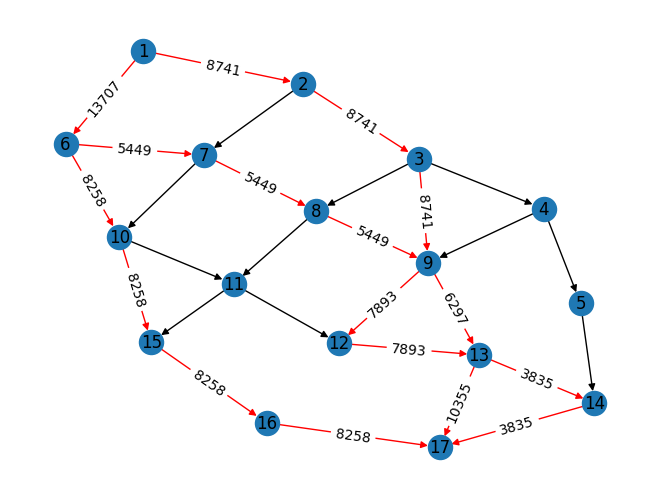

In [249]:
# Draw max-flow:
for e in edge_list:
    G.edges[int(e[0]), int(e[1])]['color'] = 'black'

path = np.where(f_max != 0)[0]

labels = {}
for p in path:
    e = edge_list[p]
    G.edges[e]['color'] = 'r'
    labels[e] = int(f_max[p])

col = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, pos, with_labels=True, edge_color = col)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)




In [250]:
# C:
nu = B @ flow
print("Nu:",nu)

Nu: [ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


In [251]:
# D:
nu[range(1,16)] = 0
nu[16] = -nu[0]

# Define & solve optimization problem to find the social optimum:
f_optim = cp.Variable(n_edges)
lc = cp.multiply(l, C)
obj_func = cp.sum(cp.multiply(lc, cp.power(np.full(n_edges, 1) - cp.multiply(f_optim, cp.power(C, -1)), -1)) - lc)
constraints = [B @ f_optim == nu, f_optim >=0, f_optim <= C]
prob = cp.Problem(cp.Minimize(obj_func), constraints)
res = prob.solve()

# Clean result & print
f_optim.value[f_optim.value < threshold] = 0
optimum_cost =  cp.sum(cp.multiply(lc, cp.power(np.full(n_edges, 1) - cp.multiply(f_optim, cp.power(C, -1)), -1)) - lc)
f_optim = np.rint(f_optim.value)
print("Social optimum:", f_optim)
print("Social optimum's cost:", optimum_cost.value)

Social optimum: [6375. 5665. 2905. 2905. 9907. 4528. 2951. 2487. 3018.  709.    0. 2761.
    0. 2905. 5379. 2766. 4900. 2287.  463. 2230. 3229. 5459. 2307.    0.
 6170. 5212. 4900. 4900.]
Social optimum's cost: 23997.159599595674


{(1, 2): Text(-0.30996390327342493, 0.9202348934374538, '6375'),
 (2, 3): Text(0.0852289845139329, 0.6618124490368518, '5665'),
 (3, 4): Text(0.43092889389721445, 0.3632080580282824, '2905'),
 (4, 5): Text(0.6633377506693514, 0.016448973818761425, '2905'),
 (1, 6): Text(-0.6502031835328423, 0.7776020331258409, '9907'),
 (6, 7): Text(-0.5627513243035035, 0.527638167341556, '4528'),
 (7, 8): Text(-0.20290621804979248, 0.3657656898774193, '2951'),
 (8, 9): Text(0.11887497084132259, 0.10776133731018955, '2487'),
 (9, 13): Text(0.3525214949038866, -0.23641940464135602, '3018'),
 (2, 7): Text(-0.22251692283811841, 0.6702729089824602, '709'),
 (3, 9): Text(0.26563316578285545, 0.23362016282393028, '2761'),
 (5, 14): Text(0.7362290475813427, -0.4486910180654111, '2905'),
 (6, 10): Text(-0.6845326306354593, 0.3324623247626357, '5379'),
 (10, 11): Text(-0.4435354019286795, -0.003523121894326131, '2766'),
 (10, 15): Text(-0.5614503480220544, -0.14277328106295584, '4900'),
 (7, 10): Text(-0.485667

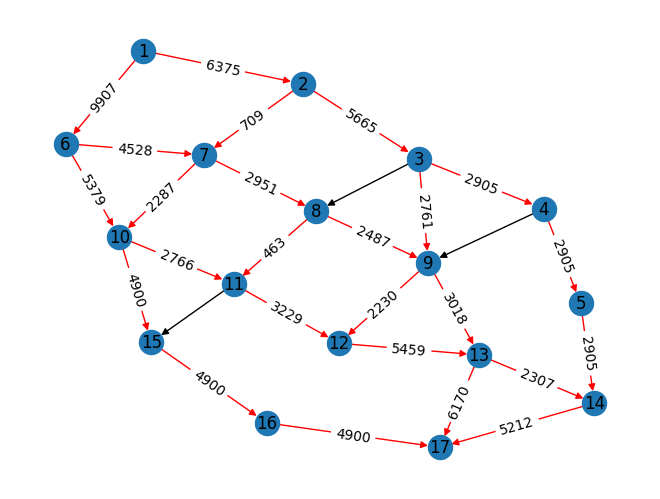

In [252]:
# Draw social optimum:
for e in edge_list:
    G.edges[int(e[0]), int(e[1])]['color'] = 'black'

path = np.where(f_optim != 0)[0]

labels = {}
for p in path:
    e = edge_list[p]
    G.edges[e]['color'] = 'r'
    labels[e] = int(f_optim[p])

col = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, pos, with_labels=True, edge_color = col)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [253]:
# E:

#Compute Wardrop equilibrium
obj_func = np.empty(n_edges)
f = cp.Variable(n_edges)

obj_func = cp.sum(
    cp.multiply(
        -lc, cp.log1p(-cp.multiply(f, cp.power(C, -1)))
    )
)

constraints = [B@f == nu, f >= 0, f <= C]
prob = cp.Problem(cp.Minimize(obj_func), constraints)
res = prob.solve()

# Clean result & print:
f.value[f.value < threshold] = 0
f = np.rint(f.value)
wardrop_cost =  cp.sum(cp.multiply(lc, cp.power(np.full(n_edges, 1) - cp.multiply(f, cp.power(C, -1)), -1)) - lc)
print("Wardrop's equilibrium:", f)
print("Equilibrium's cost:", wardrop_cost.value)
print("PoA: ", wardrop_cost.value/optimum_cost.value)

Wardrop's equilibrium: [6350. 6178. 2038. 2038. 9932. 4567. 2738. 2144. 3271.  171.   69. 4071.
    0. 2038. 5365. 2203. 5163. 2001.  663. 2945. 2866. 5811. 2437.    0.
 6645. 4474. 5163. 5163.]
Equilibrium's cost: 24341.877566920764
PoA:  1.0143649487304698


{(1, 2): Text(-0.30996390327342493, 0.9202348934374538, '6350'),
 (2, 3): Text(0.0852289845139329, 0.6618124490368518, '6178'),
 (3, 4): Text(0.43092889389721445, 0.3632080580282824, '2038'),
 (4, 5): Text(0.6633377506693514, 0.016448973818761425, '2038'),
 (1, 6): Text(-0.6502031835328423, 0.7776020331258409, '9932'),
 (6, 7): Text(-0.5627513243035035, 0.527638167341556, '4567'),
 (7, 8): Text(-0.20290621804979248, 0.3657656898774193, '2738'),
 (8, 9): Text(0.11887497084132259, 0.10776133731018955, '2144'),
 (9, 13): Text(0.3525214949038866, -0.23641940464135602, '3271'),
 (2, 7): Text(-0.22251692283811841, 0.6702729089824602, '171'),
 (3, 8): Text(0.1048508414026279, 0.35731059871073323, '69'),
 (3, 9): Text(0.26563316578285545, 0.23362016282393028, '4071'),
 (5, 14): Text(0.7362290475813427, -0.4486910180654111, '2038'),
 (6, 10): Text(-0.6845326306354593, 0.3324623247626357, '5365'),
 (10, 11): Text(-0.4435354019286795, -0.003523121894326131, '2203'),
 (10, 15): Text(-0.56145034802

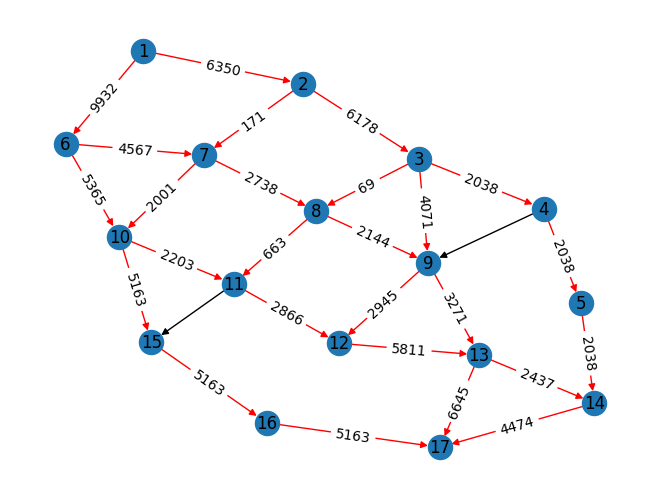

In [254]:
# Draw wardrop equilibrium:
for e in edge_list:
    G.edges[int(e[0]), int(e[1])]['color'] = 'black'

path = np.where(f != 0)[0]

labels = {}
for p in path:
    e = edge_list[p]
    G.edges[e]['color'] = 'r'
    labels[e] = int(f[p])

col = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, pos, with_labels=True, edge_color = col)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [255]:
#F:

# Compute toll vector
w = np.empty(n_edges)
for i in range(0, n_edges):
    w[i] = f_optim[i] * C[i]*l[i]/pow(C[i]-f_optim[i], 2)

# Define the optimization problem to compute the new equilibrium
f_toll = cp.Variable(n_edges)
obj_func = cp.sum(
    cp.multiply(
        -lc, cp.log1p(-cp.multiply(f_toll, cp.power(C, -1)))
    ) + cp.multiply(w, f_toll)
)
constraints = [B@f_toll == nu, f_toll >= 0, f_toll <= C]
prob = cp.Problem(cp.Minimize(obj_func), constraints)
res = prob.solve()

# Clean result and compute cost
f_toll.value[f_toll.value < threshold] = 0
f_toll = np.rint(f_toll.value)
toll_cost = cp.sum(cp.multiply(lc, cp.power(np.full(n_edges, 1) - cp.multiply(f_toll, cp.power(C, -1)), -1)) - lc)


print("Equilibrium after tolls:", f_toll)
print("Cost of the new equilibrium:", toll_cost.value)

Equilibrium after tolls: [6371. 5665. 2904. 2904. 9911. 4528. 2950. 2488. 3019.  705.    0. 2761.
    0. 2904. 5383. 2768. 4899. 2284.  462. 2230. 3230. 5460. 2308.    0.
 6171. 5212. 4899. 4899.]
Cost of the new equilibrium: 23997.058999671437


{(1, 2): Text(-0.30996390327342493, 0.9202348934374538, '6371'),
 (2, 3): Text(0.0852289845139329, 0.6618124490368518, '5665'),
 (3, 4): Text(0.43092889389721445, 0.3632080580282824, '2904'),
 (4, 5): Text(0.6633377506693514, 0.016448973818761425, '2904'),
 (1, 6): Text(-0.6502031835328423, 0.7776020331258409, '9911'),
 (6, 7): Text(-0.5627513243035035, 0.527638167341556, '4528'),
 (7, 8): Text(-0.20290621804979248, 0.3657656898774193, '2950'),
 (8, 9): Text(0.11887497084132259, 0.10776133731018955, '2488'),
 (9, 13): Text(0.3525214949038866, -0.23641940464135602, '3019'),
 (2, 7): Text(-0.22251692283811841, 0.6702729089824602, '705'),
 (3, 9): Text(0.26563316578285545, 0.23362016282393028, '2761'),
 (5, 14): Text(0.7362290475813427, -0.4486910180654111, '2904'),
 (6, 10): Text(-0.6845326306354593, 0.3324623247626357, '5383'),
 (10, 11): Text(-0.4435354019286795, -0.003523121894326131, '2768'),
 (10, 15): Text(-0.5614503480220544, -0.14277328106295584, '4899'),
 (7, 10): Text(-0.485667

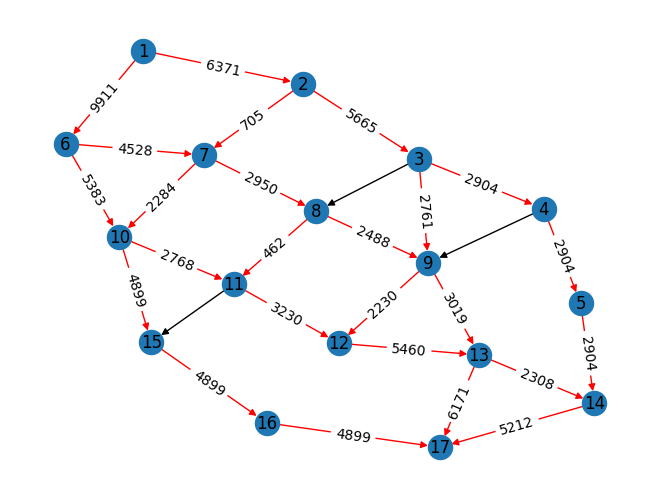

In [256]:
# Draw wardrop equilibrium after tolls:
for e in edge_list:
    G.edges[int(e[0]), int(e[1])]['color'] = 'black'

path = np.where(f_toll != 0)[0]

labels = {}
for p in path:
    e = edge_list[p]
    G.edges[e]['color'] = 'r'
    labels[e] = int(f_toll[p])

col = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, pos, with_labels=True, edge_color = col)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [257]:
#G:

# Compute social optimum:
f_optim = cp.Variable(n_edges)
obj_func = cp.sum(cp.multiply(lc, cp.power(np.full(n_edges, 1) - cp.multiply(f_optim, cp.power(C, -1)), -1)) - lc - cp.multiply(f_optim, l))
constraints = [B@f_optim == nu, f_optim >= 0, f_optim <= C]
prob = cp.Problem(cp.Minimize(obj_func), constraints)
res = prob.solve()

f_optim.value[f_optim.value < threshold] = 0
f_optim = np.rint(f_optim.value)

optim_cost = cp.sum(cp.multiply(lc, cp.power(np.full(n_edges, 1) - cp.multiply(f_optim, cp.power(C, -1)), -1)) - lc)

print("Social optimum: ", f_optim)
print("Optimal cost: ", optim_cost.value)

# Compute toll vector:
w = np.empty(n_edges)
for i in range(0, n_edges):
    w[i] = f_optim[i]*l[i]*(2*C[i]-f_optim[i])/pow(C[i]-f_optim[i], 2) - l[i]/(1-f_optim[i]/C[i])

# Compute new Wardrop equilibrium:
f_toll = cp.Variable(n_edges)
obj_func = cp.sum(
    cp.multiply(
        -lc, cp.log1p(-cp.multiply(f_toll, cp.power(C, -1)))
    ) + cp.multiply(w, f_toll)
)

constraints = [B@f_toll == nu, f_toll >= 0, f_toll <= C]
prob = cp.Problem(cp.Minimize(obj_func), constraints)
res = prob.solve()
f_toll.value[f_toll.value < threshold] = 0
f_toll = np.rint(f_toll.value)


toll_cost = cp.sum(cp.multiply(lc, cp.power(np.full(n_edges, 1) - cp.multiply(f_toll, cp.power(C, -1)), -1)) - lc + w)

print("\nEquilibrium after tolls:", f_toll)
print("Equilibrium's cost:", toll_cost.value)


Social optimum:  [6394. 5421. 3244. 3244. 9888. 4530. 3052. 2612. 2895.  973.    0. 2177.
    0. 3244. 5357. 2970. 4840. 2452.  440. 1894. 3409. 5303. 2140.    0.
 6058. 5384. 4840. 4840.]
Optimal cost:  24044.278681665888

Equilibrium after tolls: [6393. 5421. 3243. 3243. 9889. 4532. 3051. 2612. 2897.  972.    0. 2178.
    0. 3243. 5357. 2970. 4839. 2452.  439. 1893. 3410. 5303. 2141.    0.
 6059. 5384. 4839. 4839.]
Equilibrium's cost: 24047.735798404192


{(1, 2): Text(-0.30996390327342493, 0.9202348934374538, '6394'),
 (2, 3): Text(0.0852289845139329, 0.6618124490368518, '5421'),
 (3, 4): Text(0.43092889389721445, 0.3632080580282824, '3244'),
 (4, 5): Text(0.6633377506693514, 0.016448973818761425, '3244'),
 (1, 6): Text(-0.6502031835328423, 0.7776020331258409, '9888'),
 (6, 7): Text(-0.5627513243035035, 0.527638167341556, '4530'),
 (7, 8): Text(-0.20290621804979248, 0.3657656898774193, '3052'),
 (8, 9): Text(0.11887497084132259, 0.10776133731018955, '2612'),
 (9, 13): Text(0.3525214949038866, -0.23641940464135602, '2895'),
 (2, 7): Text(-0.22251692283811841, 0.6702729089824602, '973'),
 (3, 9): Text(0.26563316578285545, 0.23362016282393028, '2177'),
 (5, 14): Text(0.7362290475813427, -0.4486910180654111, '3244'),
 (6, 10): Text(-0.6845326306354593, 0.3324623247626357, '5357'),
 (10, 11): Text(-0.4435354019286795, -0.003523121894326131, '2970'),
 (10, 15): Text(-0.5614503480220544, -0.14277328106295584, '4840'),
 (7, 10): Text(-0.485667

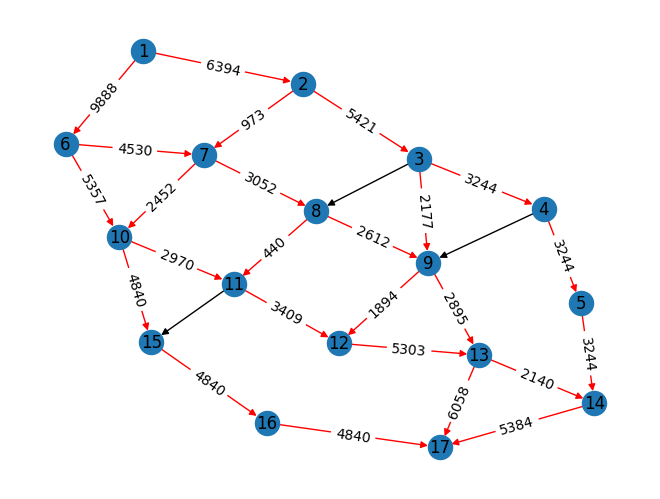

In [258]:
# Draw alternative social optimum:
for e in edge_list:
    G.edges[int(e[0]), int(e[1])]['color'] = 'black'

path = np.where(f_optim != 0)[0]

labels = {}
for p in path:
    e = edge_list[p]
    G.edges[e]['color'] = 'r'
    labels[e] = int(f_optim[p])

col = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, pos, with_labels=True, edge_color = col)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

{(1, 2): Text(-0.30996390327342493, 0.9202348934374538, '6393'),
 (2, 3): Text(0.0852289845139329, 0.6618124490368518, '5421'),
 (3, 4): Text(0.43092889389721445, 0.3632080580282824, '3243'),
 (4, 5): Text(0.6633377506693514, 0.016448973818761425, '3243'),
 (1, 6): Text(-0.6502031835328423, 0.7776020331258409, '9889'),
 (6, 7): Text(-0.5627513243035035, 0.527638167341556, '4532'),
 (7, 8): Text(-0.20290621804979248, 0.3657656898774193, '3051'),
 (8, 9): Text(0.11887497084132259, 0.10776133731018955, '2612'),
 (9, 13): Text(0.3525214949038866, -0.23641940464135602, '2897'),
 (2, 7): Text(-0.22251692283811841, 0.6702729089824602, '972'),
 (3, 9): Text(0.26563316578285545, 0.23362016282393028, '2178'),
 (5, 14): Text(0.7362290475813427, -0.4486910180654111, '3243'),
 (6, 10): Text(-0.6845326306354593, 0.3324623247626357, '5357'),
 (10, 11): Text(-0.4435354019286795, -0.003523121894326131, '2970'),
 (10, 15): Text(-0.5614503480220544, -0.14277328106295584, '4839'),
 (7, 10): Text(-0.485667

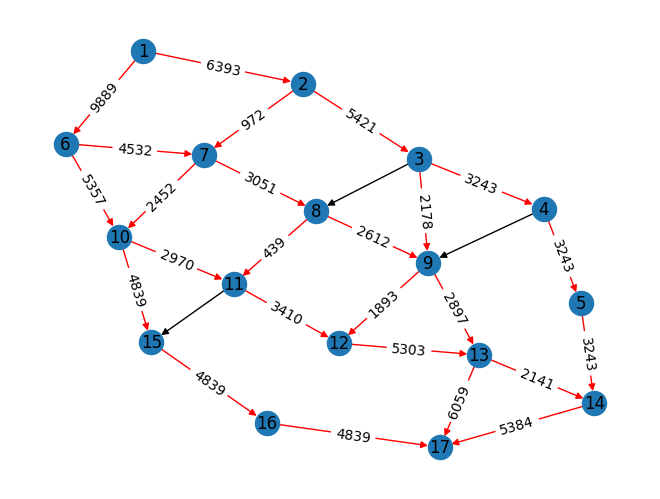

In [259]:
# Draw alternative tolled wardrop equilibrium:

for e in edge_list:
    G.edges[int(e[0]), int(e[1])]['color'] = 'black'

path = np.where(f_toll != 0)[0]

labels = {}
for p in path:
    e = edge_list[p]
    G.edges[e]['color'] = 'r'
    labels[e] = int(f_toll[p])

col = nx.get_edge_attributes(G, 'color').values()
nx.draw(G, pos, with_labels=True, edge_color = col)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)